## Implementation of a Baseline Recommender System using Factorization Machine from the 'pylibfm' library

In [1]:
import sys
!{sys.executable} -m pip install git+https://github.com/coreylynch/pyFM

  Cloning https://github.com/coreylynch/pyFM to /tmp/pip-req-build-5t_xi51m
  Running command git clone --filter=blob:none --quiet https://github.com/coreylynch/pyFM /tmp/pip-req-build-5t_xi51m
  Resolved https://github.com/coreylynch/pyFM to commit 0696c980993889a9429e4ab0b6c7dc8be6dac4de
  Preparing metadata (setup.py) ... done
  Created wheel for pyfm: filename=pyfm-0.0.0-cp310-cp310-linux_x86_64.whl size=65075 sha256=5b3f35f489119bee92d799ae3901068204b1a11f6f4c53fb58991bda8aece402
  Stored in directory: /tmp/pip-ephem-wheel-cache-u2sn10ge/wheels/fa/5d/da/7f914f89db79e7442033d9c67bff7973fc17b514b7f379a4f7
Successfully built pyfm


In [2]:
# 1. Import all the necessary libraries

from abc import ABC, abstractmethod
import random
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfm import pylibfm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [3]:
# 2. Load the data
ratings_df = pd.read_csv('kiva_ratings.csv', names=['user_id', 'item_id', 'rating'])
print(ratings_df.head(5))

                            user_id  item_id  rating
0  00043ad3146f033d4bf1beb502fa6e09       41     3.0
1  00043ad3146f033d4bf1beb502fa6e09       60     3.0
2  00043ad3146f033d4bf1beb502fa6e09      175     3.0
3  00043ad3146f033d4bf1beb502fa6e09      191     3.0
4  00043ad3146f033d4bf1beb502fa6e09      265     3.0


In [4]:
# 3.1 Training, test, validation sets
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [5]:
# 3.2 Save the splits
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)

In [6]:
# 4. Data Loading Code
'''
This function loads the data from a CSV file, creating a list of user-item interactions and a corresponding array of ratings. It also collects unique users and items.
'''
def loadData(filename,path="", sample=1.0):
    data = []
    y = []
    users=set()
    items=set()
    with open(path+filename) as f:
        next(f)
        for line in f:
            (user,itemid,rating)=line.split(',')
            if random.random() <= sample:
                data.append({ "user_id": str(user), "item_id": str(itemid)})

                y.append(float(rating))

                users.add(user)
                items.add(itemid)

    return (data, np.array(y), users, items)

In [7]:
# 5. UserRecommendations & TestRecommendations
'''
These are utility classes for storing and handling user recommendations. They allow adding entries, selecting top recommendations, and iterating over recommendations.
'''

class UserRecommendations:
    
    def __init__(self):
        self.recs = []
        
    def add_entry(self, entry):
        self.recs.append(entry)
        
    def select_top(self, k):
        self.recs = sorted(self.recs, key=lambda entry: entry[2], reverse=True)
        if len(self.recs) > k:
            self.recs = self.recs[0:k]
            
        
class TestRecommendations:
    
    def __init__(self):
        self.test_recs = defaultdict(UserRecommendations)
        
    def setup(self, preds, k):
        for entry in preds:
            user = entry.uid
            self.test_recs[user].add_entry(entry)
                   
        for user in self.test_recs.keys():
            self.test_recs[user].select_top(k)
            
    def add_entry(self, user, entry):
        self.test_recs[user].add_entry(entry)
        
    def select_top(self, user, k):
        self.test_recs[user].select_top(k)
            
    def iter_recs(self):
        for user in self.test_recs.keys():
            yield (user, self.test_recs[user].recs)               
    def get_all_recommendations(self):
        all_recs = {}
        for user in self.test_recs.keys():
            all_recs[user] = self.test_recs[user].recs
        return all_recs

In [8]:
# 6.1 Evaluator Framework
'''
These are abstract classes defining a framework for evaluating the recommender system. They provide a structure for implementing specific evaluation metrics.
'''
from abc import ABC, abstractmethod

class Evaluator(ABC):
    
    def __init__(self):
        self.results_table = None
        self.score = None
        
    def setup(self, trainset, testset):
        pass
    
    @abstractmethod
    def evaluate_user(self, user, user_recs):
        pass
    
    def evaluate(self, test_recs: TestRecommendations):
        scores = []
        self.results_table = {}
        for user, recs in test_recs.iter_recs():
            score = self.evaluate_user(user, recs)
            scores.append(score)
            self.results_table[user] = score
        self.score = np.mean(scores)
        
class ItemwiseEvaluator(Evaluator):
    
    def __init__(self):
        super().__init__()
    
    def evaluate_user(self, user, user_recs):
        return np.mean([self.evaluate_pred(rec) for rec in user_recs])
        
    @abstractmethod
    def evaluate_pred(self, pred):
        pass
    
class ListwiseEvaluator(Evaluator):
    
    def __init__(self):
        super().__init__()
    
    @abstractmethod
    def evaluate_user(self, user, user_recs):
        pass

In [9]:
# 6.2 NDCG Evaluator

class NDCGEvaluator(ListwiseEvaluator):
    
    def __init__(self, k):
        super().__init__()
        self.rated_table = defaultdict(set)
        self.idcg_table = {}
        self.log_table = {}
        self.list_len = k
    
    def setup(self, trainset, testset):
        for entry in testset:
            self.rated_table[entry['user_id']].add(entry['item_id'])
        idcg = 0
        for i in range(0, self.list_len+1):
            self.idcg_table[i] = idcg
            rank_utility = 1 / np.log(i+2)
            self.log_table[i] = rank_utility
            idcg += rank_utility
            
    
    def evaluate_user(self, user, user_recs): 
        
        dcg = 0.0
        for i, pred in enumerate(user_recs):
            if pred[1] in self.rated_table[user]:
                dcg = self.log_table.get(i, 0)

        
        idcg = 0
        if len(self.rated_table[user]) >= self.list_len:
               idcg = self.idcg_table[self.list_len]
        else:
               idcg = self.idcg_table[len(self.rated_table[user])]
            
        if idcg == 0:
            return 0
        return dcg/idcg

In [10]:
# 7. Prediction generation code
'''
This code generates recommendation lists on the fly for users in the test data (avoiding the need for "anti-test data". 
It samples the training items for the "distractor" items that are being predicted and it also samples the users so that evaluation is more efficient.
'''


def create_prediction_profiles(test_data, train_items, predict_list_len, frac=1.0):
    train_items_lst = list(train_items)  # Convert set to list
    user_test_profile = defaultdict(set)

    for entry in test_data:
        user_id = entry['user_id']
        item_id = entry['item_id']
        user_test_profile[user_id].add(item_id)
    
    test_users = list(user_test_profile.keys())
    test_users_select = random.sample(test_users, int(frac * len(test_users)))
                      
    user_predict_profile = {}

    for user in test_users_select:
        profile = user_test_profile[user]
        num_sample = min(predict_list_len, len(train_items_lst) - len(profile))
        sample_items = random.sample(train_items_lst, num_sample) + list(profile)
        user_predict_profile[user] = sample_items
        
    return user_predict_profile    

def create_test_recommendations(predict_fn, vectorizer, test_data, list_len, train_items, predict_list_len, frac=1.0):
    user_predict_profile = create_prediction_profiles(test_data, train_items, predict_list_len, frac)
    
    trecs = TestRecommendations()
    
    for user, profile in user_predict_profile.items():
        
        for item in profile:
            x_test = vectorizer.transform({'user_id': user, 'item_id': item})
            pred = predict_fn(x_test)[0]
            trecs.add_entry(user, (user, item, pred))
        trecs.select_top(user, list_len)
        
    return trecs

In [11]:
# 8.1 Load the data usingloadData function
train_data, y_train, train_users, train_items = loadData('train_data.csv')
test_data, y_test, test_users, test_items = loadData('test_data.csv')

In [12]:
# 8.2 Vectorize
vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_data)
X_test = vectorizer.transform(test_data)

In [28]:
# 9. Factorization Machine Model Training and Prediction
latent_factors = range(20, 101, 20)
ndcg_scores = []
frac = 0.1
predict_list_len = 100
list_len = 50 

for factors in latent_factors:
    fm = pylibfm.FM(num_factors=factors, num_iter=5, verbose=True, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")
    fm.fit(X_train, y_train)
    
    test_recommendations = create_test_recommendations(
        predict_fn=fm.predict, 
        vectorizer=vectorizer, 
        test_data=test_data, 
        train_items=train_items, 
        list_len=50, 
        predict_list_len=100, 
        frac=frac
    )
  
    ndcg_evaluator = NDCGEvaluator(k=10)  #evaluate top 10 recommendations 

    ndcg_evaluator.setup(train_data, test_data)

    all_ndcg_scores = []
    for user, recs in test_recommendations.iter_recs():
        user_recs = [(user, rec[1], rec[2]) for rec in recs]
        ndcg_score = ndcg_evaluator.evaluate_user(user, user_recs)
        all_ndcg_scores.append(ndcg_score)

    avg_ndcg_score = np.mean(all_ndcg_scores)
    ndcg_scores.append(avg_ndcg_score)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.09788
-- Epoch 2
Training MSE: 0.09331
-- Epoch 3
Training MSE: 0.09101
-- Epoch 4
Training MSE: 0.08930
-- Epoch 5
Training MSE: 0.08793
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.09877
-- Epoch 2
Training MSE: 0.09414
-- Epoch 3
Training MSE: 0.09168
-- Epoch 4
Training MSE: 0.08982
-- Epoch 5
Training MSE: 0.08829
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.09947
-- Epoch 2
Training MSE: 0.09477
-- Epoch 3
Training MSE: 0.09217
-- Epoch 4
Training MSE: 0.09012
-- Epoch 5
Training MSE: 0.08841
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.10037
-- Epoch 2
Training MSE: 0.09551
-- Epoch 3
Training MSE: 0.09273
-- Epoch 4
Training MSE: 0.09054
-- Epoch 5
Training MSE: 0.08868
Creating validation dataset of 0.01 

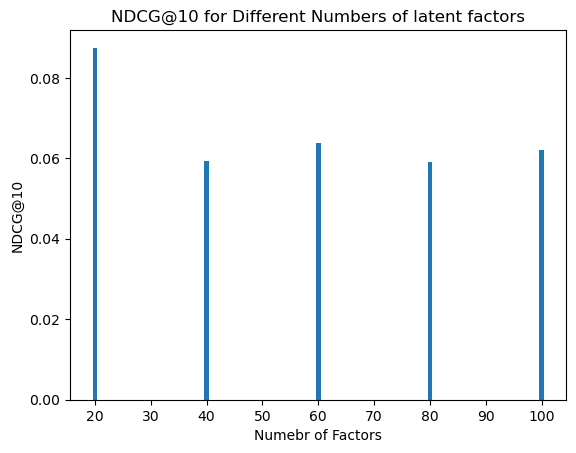

[0.08747728242292903,
 0.05941406366189888,
 0.06382585587372165,
 0.05918626949837014,
 0.06208436563783633]

In [29]:
# 10. Plotting the NDCG scores
plt.bar(range(20,101,20), ndcg_scores)
plt.xlabel('Numebr of Factors')
plt.ylabel('NDCG@10')
plt.title('NDCG@10 for Different Numbers of latent factors')
plt.show()
ndcg_scores

In [30]:
# 11. select 20 factors as the best model
train_data_np = np.array(train_data)
best_num_factors = 20
best_model = pylibfm.FM(num_factors=best_num_factors, num_iter=5, verbose=True, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")
best_model.fit(X_train, y_train)

test_recommendations = create_test_recommendations(
    predict_fn=best_model.predict, 
    vectorizer=vectorizer, 
    test_data=test_data, 
    train_items=train_items, 
    list_len=50,  
    predict_list_len=100, 
    frac=frac
)

ndcg_evaluator = NDCGEvaluator(k=10) 

ndcg_evaluator.setup(train_data, test_data) 


# Ndcg scores
ndcg_scores = []
for user, recs in test_recommendations.iter_recs():
    user_recs = [(user, rec[1], rec[2]) for rec in recs]
    ndcg_score = ndcg_evaluator.evaluate_user(user, user_recs)
    ndcg_scores.append(ndcg_score)

final_ndcg_score = np.mean(ndcg_scores)

# Output final scores
print("Final NDCG Score:", final_ndcg_score)



Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.09794
-- Epoch 2
Training MSE: 0.09324
-- Epoch 3
Training MSE: 0.09097
-- Epoch 4
Training MSE: 0.08924
-- Epoch 5
Training MSE: 0.08785
Final NDCG Score: 0.09442131089085491


In [31]:
# 12. Get the final output (after training the model and creating the test_recommendations)
all_user_recommendations = test_recommendations.get_all_recommendations()
output_df = pd.DataFrame([(user, item, score) for user, recs in all_user_recommendations.items() for _, item, score in recs], columns=['user', 'item', 'score'])
output_df.to_csv('user_recommendations.csv', index=False, header=False)